In [1]:
from __future__ import print_function, division

In [62]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import shutil
import requests

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar
from astropy.utils import data

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)

In [5]:
SDSS_SQL_URL = 'http://skyserver.sdss.org/dr13/SkyServerWS/SearchTools/SqlSearch'

def in_sdss(sc):
    res = requests.get(SDSS_SQL_URL, dict(cmd="select dbo.fInFootprintEq({0.ra.deg},{0.dec.deg},0.1)".format(sc), 
                                          format='csv'))
    return 'True' in res.text.split('\n')

In [6]:
ls decals_dr3/

catalogs/                      survey-bricks.fits.gz
dr3-depth.fits.gz              survey-ccds-decals.fits.gz
in_sdss.npy                    survey-ccds-extra.fits.gz
survey-bricks-dr3.fits.gz      survey-ccds-nondecals.fits.gz


# Load up the DECALS info tables 

In [7]:
bricks = Table.read('decals_dr3/survey-bricks.fits.gz')

bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')

fn_in_sdss = 'decals_dr3/in_sdss.npy'

try:
    bricksdr3['in_sdss'] = np.load(fn_in_sdss)
except:
    bricksdr3['in_sdss'] = ['unknown']*len(bricksdr3)
bricksdr3

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,ebv,trans_g,trans_r,trans_z,in_sdss
str8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,str7
0001m002,0.125,-0.25,5,5,3,7243 .. 10372260,26934 .. 6382259,47924 .. 761379,5232,3048,1146,805,213,20,1.69414,1.27605,1.09967,0.0340012,0.904249,0.934448,0.962786,unknown
0001m005,0.125,-0.5,5,5,3,478 .. 9576106,1434 .. 6016184,4937 .. 585314,5363,2880,1350,920,188,25,1.71339,1.26142,1.10811,0.0411628,0.885281,0.921198,0.955126,unknown
0001m007,0.125,-0.75,7,5,2,481 .. 10090641,969 .. 7820925,5096 .. 0,5571,3069,1321,940,223,18,1.77402,1.27084,1.10699,0.0434682,0.87926,0.916973,0.952673,unknown
0001m010,0.125,-1.0,12,4,3,500 .. 11776043,3600 .. 4475110,6176 .. 174583,5458,3209,1208,814,196,31,1.82827,1.3262,1.05196,0.0380431,0.893494,0.926947,0.958455,unknown
0001m012,0.125,-1.25,8,4,3,770 .. 10335956,1544 .. 5702394,2709 .. 0,5173,3043,1211,744,159,16,1.8143,1.31533,1.04816,0.0409226,0.885911,0.921639,0.955382,unknown
0001m015,0.125,-1.5,7,3,2,534 .. 11043808,2769 .. 0,4860 .. 0,5718,3349,1348,806,197,18,1.85323,1.26542,1.06301,0.0366314,0.897236,0.92956,0.959966,unknown
0001m017,0.125,-1.75,7,4,3,861 .. 10208781,3266 .. 0,3506 .. 0,5738,3312,1297,894,215,20,1.8339,1.24556,1.03952,0.0356847,0.899754,0.931316,0.96098,unknown
0001m020,0.125,-2.0,6,3,3,4458 .. 10243608,18998 .. 0,19897 .. 0,5667,3277,1355,825,197,13,1.83324,1.25349,1.0373,0.0368048,0.896775,0.929238,0.95978,unknown
0001m022,0.125,-2.25,6,3,3,1893 .. 10062157,6350 .. 0,5708 .. 0,5582,3249,1252,867,196,18,1.84481,1.26543,1.03051,0.0365192,0.897534,0.929768,0.960086,unknown


In [8]:
goodbricks = (bricksdr3['in_sdss'] == 'unknown') & (bricksdr3['nexp_r']>=10)

if np.sum(goodbricks) > 0:
    for brick in ProgressBar(bricksdr3[goodbricks], ipython_widget=True):
        sc = SkyCoord(brick['ra']*u.deg, brick['dec']*u.deg)
        bricksdr3['in_sdss'][bricksdr3['brickname']==brick['brickname']] = 'yes' if in_sdss(sc) else 'no'

    np.save('decals_dr3/in_sdss', bricksdr3['in_sdss'])

(-30, 40)

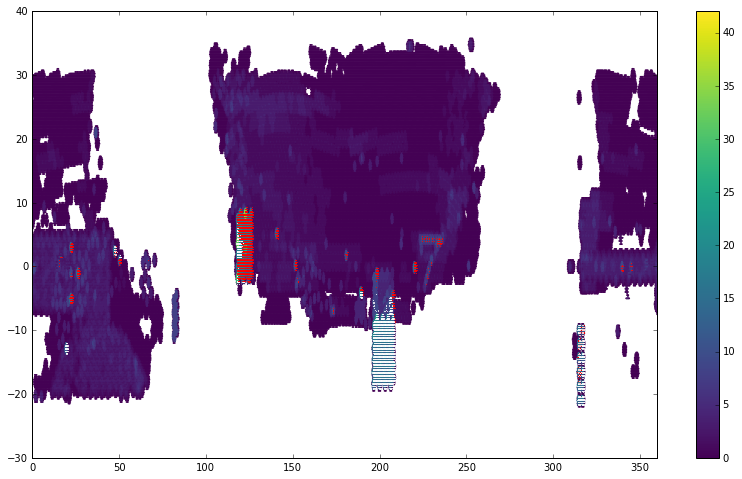

In [9]:
plt.scatter(bricksdr3['ra'], bricksdr3['dec'], 
            c=bricksdr3['nexp_r'], lw=0, s=3, vmin=0)
plt.colorbar()


yeses = bricksdr3['in_sdss'] == 'yes'
nos = bricksdr3['in_sdss'] == 'no'
plt.scatter(bricksdr3['ra'][yeses], bricksdr3['dec'][yeses], c='r',lw=0, s=1)
plt.scatter(bricksdr3['ra'][nos], bricksdr3['dec'][nos], c='w',lw=0, s=1)
plt.xlim(0, 360)
plt.ylim(-30, 40)

(-30, 40)

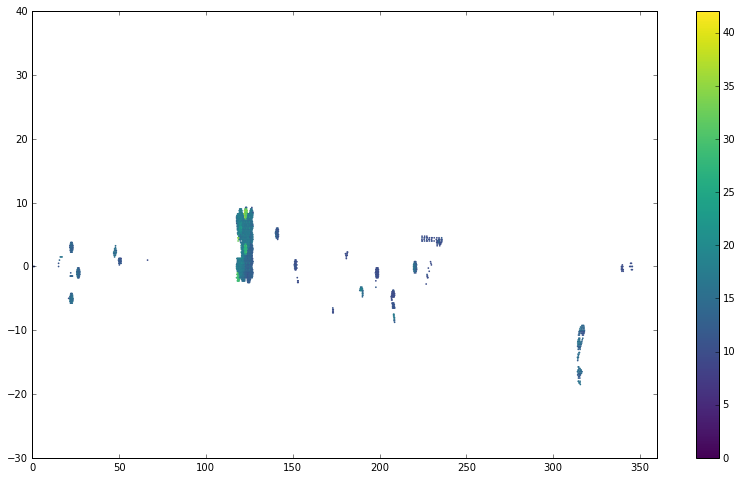

In [10]:
sdssbricks = bricksdr3[bricksdr3['in_sdss']=='yes']
plt.scatter(sdssbricks['ra'], sdssbricks['dec'], 
            c=sdssbricks['nexp_r'], lw=0, s=3, vmin=0)
plt.colorbar()
plt.xlim(0, 360)
plt.ylim(-30, 40)

### Alright, now lets just pick a few specific bricks that are both in SDSS and have fairly deep g and r data

(-1.0, 43.0)

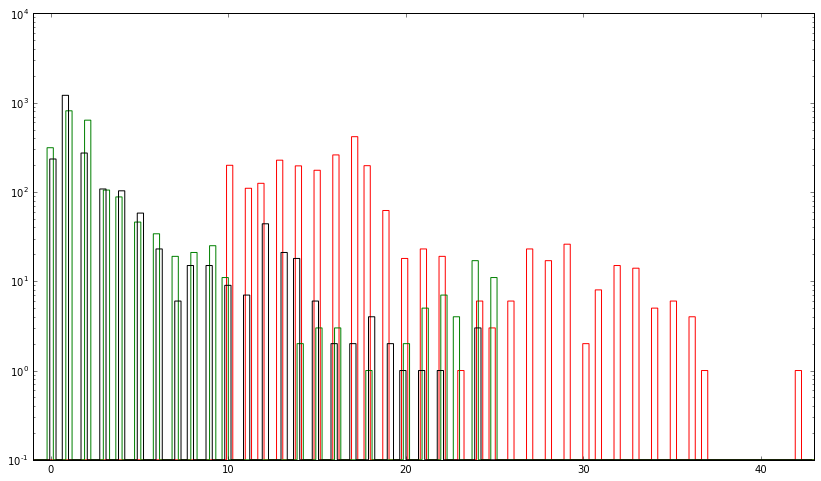

In [11]:
maxn = np.max(sdssbricks['nexp_r'])

bins = np.linspace(-1, maxn+1, maxn*3)

plt.hist(sdssbricks['nexp_r'], bins=bins, histtype='step', ec='r',log=True)
plt.hist(sdssbricks['nexp_g'], bins=bins+.1, histtype='step', ec='g',log=True)
plt.hist(sdssbricks['nexp_z'], bins=bins-.1, histtype='step', ec='k',log=True)
plt.xlim(bins[0], bins[-1])

And the joint distribution?

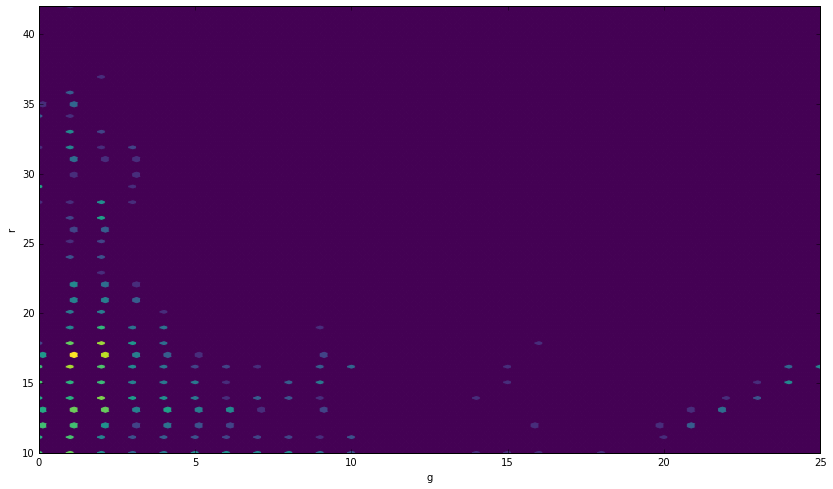

In [12]:
plt.hexbin(sdssbricks['nexp_g'], sdssbricks['nexp_r'],bins='log')
plt.xlabel('g')
plt.ylabel('r')

Looks like there isn't much with lots of r *and* lots of g... 🙁

So we pick one of each.

In [206]:
deep_r = np.random.choice(sdssbricks['brickname'][(sdssbricks['nexp_r']>20)&(sdssbricks['nexp_g']>2)])

ra = bricks[bricks['BRICKNAME']==deep_r]['RA'][0]
dec = bricks[bricks['BRICKNAME']==deep_r]['DEC'][0]
print('http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra={}&dec={}&scale=3.0&opt=P'.format(ra, dec))
deep_r

http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=119.372384937&dec=5.75&scale=3.0&opt=P


'1193p057'

In [168]:
deep_g = np.random.choice(sdssbricks['brickname'][(sdssbricks['nexp_r']>15)&(sdssbricks['nexp_g']>20)])

ra = bricks[bricks['BRICKNAME']==deep_g]['RA'][0]
dec = bricks[bricks['BRICKNAME']==deep_g]['DEC'][0]
print('http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra={}&dec={}&scale=3.0'.format(ra, dec))
deep_g

http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=220.875&dec=-0.5&scale=3.0


'2208m005'

In [207]:
#bricknames = [deep_r, deep_g]

# hard code this from the result above for repeatability
bricknames = ['1193p057', '2208m005']

sdssbricks[np.in1d(sdssbricks['brickname'], bricknames)]

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,ebv,trans_g,trans_r,trans_z,in_sdss
str8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,str7
1193p057,119.372384937,5.75,3,22,2,107636 .. 0,4339 .. 11699985,1616193 .. 0,6768,5029,661,915,137,26,1.5221,1.38293,1.26121,0.0217593,0.937619,0.957539,0.976022,yes
2208m005,220.875,-0.5,24,16,13,75 .. 11801698,501 .. 11800518,947 .. 11763454,6693,4530,977,991,172,23,1.60959,1.48308,1.23049,0.0402766,0.887606,0.922827,0.956071,yes


In [208]:
base_url = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/'

catalog_fns = []
for nm in bricknames:
    url = base_url + 'tractor/{}/tractor-{}.fits'.format(nm[:3], nm)
    outfn = 'decals_dr3/catalogs/' + os.path.split(url)[-1]
    
    if os.path.isfile(outfn):
        print(outfn, 'already exists')
    else:
        tmpfn = data.download_file(url)
        shutil.move(tmpfn, outfn)
        
    catalog_fns.append(outfn)

decals_dr3/catalogs/tractor-2208m005.fits already exists


In [209]:
catalog_fns

['decals_dr3/catalogs/tractor-1193p057.fits',
 'decals_dr3/catalogs/tractor-2208m005.fits']

# Now get the matched SDSS catalogs 

In [210]:
import casjobs

In [211]:
jobs = casjobs.CasJobs(base_url='http://skyserver.sdss.org/CasJobs/services/jobs.asmx', request_type='POST')

In [212]:
# this query template comes from Marla's download_host_sqlfile w/ modifications
query_template = """
SELECT  p.objId  as OBJID,
p.ra as RA, p.dec as DEC,
p.type as PHOTPTYPE,  dbo.fPhotoTypeN(p.type) as PHOT_SG,

p.flags as FLAGS,
flags & dbo.fPhotoFlags('SATURATED') as SATURATED,
flags & dbo.fPhotoFlags('BAD_COUNTS_ERROR') as BAD_COUNTS_ERROR,
flags & dbo.fPhotoFlags('BINNED1') as BINNED1,

p.modelMag_u as u, p.modelMag_g as g, p.modelMag_r as r,p.modelMag_i as i,p.modelMag_z as z,
p.modelMagErr_u as u_err, p.modelMagErr_g as g_err,
p.modelMagErr_r as r_err,p.modelMagErr_i as i_err,p.modelMagErr_z as z_err,

p.MODELMAGERR_U,p.MODELMAGERR_G,p.MODELMAGERR_R,p.MODELMAGERR_I,p.MODELMAGERR_Z,

p.EXTINCTION_U, p.EXTINCTION_G, p.EXTINCTION_R, p.EXTINCTION_I, p.EXTINCTION_Z,
p.DERED_U,p.DERED_G,p.DERED_R,p.DERED_I,p.DERED_Z,

p.PETRORAD_U,p.PETRORAD_G,p.PETRORAD_R,p.PETRORAD_I,p.PETRORAD_Z,
p.PETRORADERR_U,p.PETRORADERR_G,p.PETRORADERR_R,p.PETRORADERR_I,p.PETRORADERR_Z,

p.DEVRAD_U,p.DEVRADERR_U,p.DEVRAD_G,p.DEVRADERR_G,p.DEVRAD_R,p.DEVRADERR_R,
p.DEVRAD_I,p.DEVRADERR_I,p.DEVRAD_Z,p.DEVRADERR_Z,
p.DEVAB_U,p.DEVAB_G,p.DEVAB_R,p.DEVAB_I,p.DEVAB_Z,

p.CMODELMAG_U, p.CMODELMAGERR_U, p.CMODELMAG_G,p.CMODELMAGERR_G,
p.CMODELMAG_R, p.CMODELMAGERR_R, p.CMODELMAG_I,p.CMODELMAGERR_I,
p.CMODELMAG_Z, p.CMODELMAGERR_Z,

p.PSFMAG_U, p.PSFMAGERR_U, p.PSFMAG_G, p.PSFMAGERR_G, 
p.PSFMAG_R, p.PSFMAGERR_R, p.PSFMAG_I, p.PSFMAGERR_I, 
p.PSFMAG_Z, p.PSFMAGERR_Z, 

p.FIBERMAG_U, p.FIBERMAGERR_U, p.FIBERMAG_G, p.FIBERMAGERR_G,
p.FIBERMAG_R, p.FIBERMAGERR_R, p.FIBERMAG_I, p.FIBERMAGERR_I,
p.FIBERMAG_Z, p.FIBERMAGERR_Z,


p.FRACDEV_U, p.FRACDEV_G, p.FRACDEV_R, p.FRACDEV_I, p.FRACDEV_Z,
p.Q_U,p.U_U, p.Q_G,p.U_G, p.Q_R,p.U_R, p.Q_I,p.U_I, p.Q_Z,p.U_Z,

p.EXPAB_U, p.EXPRAD_U, p.EXPPHI_U, p.EXPAB_G, p.EXPRAD_G, p.EXPPHI_G,
p.EXPAB_R, p.EXPRAD_R, p.EXPPHI_R, p.EXPAB_I, p.EXPRAD_I, p.EXPPHI_I,
p.EXPAB_Z, p.EXPRAD_Z, p.EXPPHI_Z,

p.FIBER2MAG_R, p.FIBER2MAGERR_R,
p.EXPMAG_R, p.EXPMAGERR_R,

p.PETROR50_R, p.PETROR90_R, p.PETROMAG_R,
p.expMag_r + 2.5*log10(2*PI()*p.expRad_r*p.expRad_r + 1e-20) as SB_EXP_R,
p.petroMag_r + 2.5*log10(2*PI()*p.petroR50_r*p.petroR50_r) as SB_PETRO_R,

ISNULL(w.j_m_2mass,9999) as J, ISNULL(w.j_msig_2mass,9999) as JERR, 
ISNULL(w.H_m_2mass,9999) as H, ISNULL(w.h_msig_2mass,9999) as HERR, 
ISNULL(w.k_m_2mass,9999) as K, ISNULL(w.k_msig_2mass,9999) as KERR,

ISNULL(s.z, -1) as SPEC_Z, ISNULL(s.zErr, -1) as SPEC_Z_ERR, ISNULL(s.zWarning, -1) as SPEC_Z_WARN, 
ISNULL(pz.z,-1) as PHOTOZ, ISNULL(pz.zerr,-1) as PHOTOZ_ERR

FROM dbo.fGetObjFromRectEq({ra1}, {dec1}, {ra2}, {dec2}) n, PhotoPrimary p
{into}
LEFT JOIN SpecObj s ON p.specObjID = s.specObjID
LEFT JOIN PHOTOZ  pz ON p.ObjID = pz.ObjID
LEFT join WISE_XMATCH as wx on p.objid = wx.sdss_objid
LEFT join wise_ALLSKY as w on  wx.wise_cntr = w.cntr
WHERE n.objID = p.objID 
"""

casjobs_tables = jobs.list_tables()

job_ids = []
for bricknm in bricknames:
    thisbrick = bricks[bricks['BRICKNAME']==bricknm]
    assert len(thisbrick) == 1
    thisbrick = thisbrick[0]
    intostr = 'INTO mydb.decals_brick_' + bricknm
    
    qry = query_template.format(ra1=thisbrick['RA1'], ra2=thisbrick['RA2'],
                                dec1=thisbrick['DEC1'], dec2=thisbrick['DEC2'],
                                into=intostr)
    if intostr.split('.')[1] in casjobs_tables:
        print(bricknm, 'already present')
        continue
    job_ids.append(jobs.submit(qry, 'DR13', bricknm))
    
# wait for the jobs to finish
finished = False
while not finished:
    for i in job_ids:
        stat = jobs.status(i)[-1]
        if stat == 'failed':
            raise ValueError('Job {} failed'.format(i))
        if stat != 'finished':
            time.sleep(1)
            break
    else:
        finished = True

print('Finished jobs', job_ids)

2208m005 already present
Finished jobs [22326376]


In [213]:
jids = []
for bnm in bricknames:
    table_name = 'decals_brick_' + bnm
    ofn = 'decals_dr3/catalogs/sdss_comparison_{}.csv'.format(bnm)
    if os.path.isfile(ofn):
        print(table_name, 'already downloaded')
    else:
        jids.append(jobs.request_output(table_name,'CSV'))
    
done_jids = []
while len(done_jids)<len(jids):
    time.sleep(1)
    for i, bnm in zip(jids, bricknames):
        if i in done_jids:
            continue
        if jobs.status(i)[-1] != 'finished':
            continue
        ofn = 'decals_dr3/catalogs/sdss_comparison_{}.csv'.format(bnm)
        jobs.get_output(i, ofn)
        done_jids.append(i)
        print(ofn)

decals_brick_2208m005 already downloaded
decals_dr3/catalogs/sdss_comparison_1193p057.csv
